# Introducción

Este Notebook presenta el proceso de análisis y modelado para predecir la probabilidad de que un cliente contrate una tarjeta de débito. Utilizaremos un conjunto de datos que contiene información sobre las características demográficas y de comportamiento de los clientes, así como sus interacciones previas con el banco.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importación de librerías y carga de datos

Importamos las librerías necesarias para el análisis y modelado de datos. Pandas se utilizará para la manipulación de datos, NumPy para operaciones numéricas, sklearn para el modelado y matplotlib para la visualización de datos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from pandas.tseries.offsets import DateOffset
from sklearn import metrics
import matplotlib.pyplot as plt

# 2. Cargar y revisar de los datos
Se carga el archivo CSV que contiene los datos y se utiliza el método info() para obtener una descripción general de los datos, incluyendo el número total de entradas y la cantidad de valores no nulos.

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/MDS - Grupo 7/Capstone/Dataset para trabajar 04.07/informacion_clientes.csv'

In [ ]:
# Cargar los datos
df = pd.read_csv(csv_path)

<ipython-input-4-3d142995c8f4>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pk_cid                  int64  
 1   pk_partition            object 
 2   entry_date              object 
 3   entry_channel           object 
 4   active_customer         int64  
 5   segment                 object 
 6   short_term_deposit      int64  
 7   loans                   int64  
 8   mortgage                int64  
 9   funds                   int64  
 10  securities              int64  
 11  long_term_deposit       int64  
 12  credit_card             int64  
 13  payroll                 int64  
 14  pension_plan            int64  
 15  payroll_account         int64  
 16  emc_account             int64  
 17  debit_card              int64  
 18  em_acount               int64  
 19  country_id              object 
 20  region_code             object 
 21  gender                  object 

Definimos debit_card como objetivo para realizar las acciones posteriores

In [ ]:
target = "debit_card"

# 3. Preprocesamiento y preparación de los datos
Se procesan los datos para prepararlos para el análisis. Esto incluye la ordenación de los datos por cliente y mes, la creación de nuevas columnas que indican si el cliente ha comprado en el mes anterior y hace dos meses, y la conversión de la columna de fecha a tipo datetime.

In [ ]:
df[target].value_counts()

0    5399956
1     562968
Name: debit_card, dtype: int64

In [ ]:
# Convertir la columna 'month_sale' a tipo de dato datetime
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

In [ ]:
df['region_code'] = df['region_code'].replace('no_data', '0.0')

In [ ]:
df['region_code'] = df['region_code'].astype(float)

In [ ]:
df['Suma_productos_activos']= df['Suma_productos_activos'] - df[target]

# 4. Creación del conjunto de datos balanceado
Aquí se utiliza la función create_dataset, la cual definimos para crear un conjunto de datos balanceado.

In [ ]:
def create_dataset(df):
    dataset = pd.DataFrame()  # Crear un DataFrame vacío para almacenar los datos muestreados
    selected_cids = set()  # Crear un conjunto para almacenar los cids seleccionados

    months = sorted(df['pk_partition'].unique())  # Almacena los meses únicos en la columna 'month_sale', en orden
    for month in months[:-1]:  # Iterar sobre todos los meses, excepto el último
        month_df = df[df['pk_partition'] == month]  # Filtrar el DataFrame original para el mes actual
        # Excluir los cids que ya han sido seleccionados
        data_with_purchase = month_df[(month_df[target] == 1) & (~month_df['pk_cid'].isin(selected_cids))]
        data_without_purchase = month_df[(month_df[target] == 0) & (~month_df['pk_cid'].isin(selected_cids))]
        sample_size = min(len(data_with_purchase), len(data_without_purchase))  # Calcular el tamaño de muestra mínimo

        print(f'Mes: {month}')  # Imprimir el mes actual
        print(f'Número de 1s: {len(data_with_purchase)}')  # Imprimir el número de 1s para el mes actual
        print(f'Número de 0s: {len(data_without_purchase)}')  # Imprimir el número de 0s para el mes actual
        print(f'Tamaño de la muestra: {sample_size}\n')  # Imprimir el tamaño de la muestra para el mes actual

        if sample_size > 0:  # Verificar que haya suficientes clientes en ambas categorías para crear un dataset equilibrado
            sampled_data_with_purchase = data_with_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que compraron
            sampled_data_without_purchase = data_without_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que no compraron
            sampled_data = pd.concat([sampled_data_with_purchase, sampled_data_without_purchase])  # Concatenar los datos muestreados
            dataset = pd.concat([dataset, sampled_data])  # Agregar los datos muestreados al dataset final
            # Actualizar los cids seleccionados
            selected_cids.update(sampled_data['pk_cid'].values)

    # Tratar el último mes por separado
    last_month = months[-1]
    last_month_df = df[df['pk_partition'] == last_month]  # Filtrar el DataFrame original para el último mes
    # Aquí no necesitamos equilibrar los datos, así que simplemente excluimos los cids que ya han sido seleccionados
    last_month_data = last_month_df[~last_month_df['pk_cid'].isin(selected_cids)]

    # Imprimir las estadísticas del último mes
    print(f'Mes: {last_month}')
    print(f'Número de 1s: {len(last_month_data[last_month_data[target] == 1])}')
    print(f'Número de 0s: {len(last_month_data[last_month_data[target] == 0])}')

    # Agregar los datos del último mes al dataset final
    dataset = pd.concat([dataset, last_month_data])

    return dataset  # Devolver el dataset consolidado de todos los meses

In [ ]:
# Crear el dataset por meses y consolidar las ventas
dataset = create_dataset(df)

Mes: 2018-01-01T00:00:00.000000000
Número de 1s: 24696
Número de 0s: 214797
Tamaño de la muestra: 24696

Mes: 2018-02-01T00:00:00.000000000
Número de 1s: 3287
Número de 0s: 189958
Tamaño de la muestra: 3287

Mes: 2018-03-01T00:00:00.000000000
Número de 1s: 2391
Número de 0s: 187145
Tamaño de la muestra: 2391

Mes: 2018-04-01T00:00:00.000000000
Número de 1s: 1880
Número de 0s: 185213
Tamaño de la muestra: 1880

Mes: 2018-05-01T00:00:00.000000000
Número de 1s: 1598
Número de 0s: 184312
Tamaño de la muestra: 1598

Mes: 2018-06-01T00:00:00.000000000
Número de 1s: 1658
Número de 0s: 183343
Tamaño de la muestra: 1658

Mes: 2018-07-01T00:00:00.000000000
Número de 1s: 1733
Número de 0s: 266586
Tamaño de la muestra: 1733

Mes: 2018-08-01T00:00:00.000000000
Número de 1s: 1746
Número de 0s: 276841
Tamaño de la muestra: 1746

Mes: 2018-09-01T00:00:00.000000000
Número de 1s: 2291
Número de 0s: 295339
Tamaño de la muestra: 2291

Mes: 2018-10-01T00:00:00.000000000
Número de 1s: 3100
Número de 0s: 317

In [ ]:
dataset[target].value_counts()

0    384912
1     59867
Name: debit_card, dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444779 entries, 174358 to 5962923
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  444779 non-null  int64         
 1   pk_partition            444779 non-null  datetime64[ns]
 2   entry_date              444779 non-null  object        
 3   entry_channel           444779 non-null  object        
 4   active_customer         444779 non-null  int64         
 5   segment                 444779 non-null  object        
 6   short_term_deposit      444779 non-null  int64         
 7   loans                   444779 non-null  int64         
 8   mortgage                444779 non-null  int64         
 9   funds                   444779 non-null  int64         
 10  securities              444779 non-null  int64         
 11  long_term_deposit       444779 non-null  int64         
 12  credit_card             

In [ ]:
last_month = dataset['pk_partition'].max()
dataset['is_last_month'] = (dataset['pk_partition'] == last_month).astype(int)

# 5. Adición de nuevas columnas y agrupación de los datos
Se añade una nueva columna que indica si los datos corresponden al último mes. Luego, se agrupan los datos por cliente, obteniendo el último valor de cada cliente para cada producto y el promedio de sus salarios.

In [ ]:
# Agrupar los datos por 'pk_cid', incluyendo la nueva columna en la operación de agrupamiento
df_grouped = dataset.groupby('pk_cid').agg({
    'pension_plan': 'last',
    #'net_margin': 'sum',
    'age': 'max',
    'salary': 'mean',
    'entry_channel': 'last',
    'segment': 'last',
    'gender': 'last',
    'region_code': 'last',
    'country_id':'last',
   #'días_para_compra':'mean',
   # 'Suma_productos_activos':'max',
    'short_term_deposit': 'last',
    'loans': 'last',
    'mortgage': 'last',
    'funds': 'last',
    'securities': 'last',
    'long_term_deposit': 'last',
    'credit_card': 'last',
    'payroll': 'last',
    'pension_plan': 'last',
    'payroll_account': 'last',
    'emc_account': 'last',
    'debit_card': 'last',
    'em_acount': 'last',
    'pk_partition':'max'  # Agregar la nueva columna
}).reset_index()

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444779 entries, 0 to 444778
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              444779 non-null  int64         
 1   pension_plan        444779 non-null  int64         
 2   age                 444779 non-null  int64         
 3   salary              444779 non-null  float64       
 4   entry_channel       444779 non-null  object        
 5   segment             444779 non-null  object        
 6   gender              444779 non-null  object        
 7   region_code         444779 non-null  float64       
 8   country_id          444779 non-null  object        
 9   short_term_deposit  444779 non-null  int64         
 10  loans               444779 non-null  int64         
 11  mortgage            444779 non-null  int64         
 12  funds               444779 non-null  int64         
 13  securities          444779 no

# 6. Codificación de variables categóricas
Las variables categóricas como el canal de entrada, el segmento y el género se codifican utilizando One-Hot Encoding para convertirlas en un formato que pueda ser utilizado por el modelo de machine learning.

In [ ]:
df_grouped = pd.get_dummies(df_grouped, columns=['entry_channel', 'segment', 'gender', 'region_code', 'country_id'])

In [ ]:
df_grouped.head(5)

,pk_cid,pension_plan,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,16063,0,62,126179.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16203,0,70,124622.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16502,0,58,126179.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17457,0,53,102406.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,17590,0,55,407281.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 7. División de los datos en conjuntos de entrenamiento, prueba y validación
Los datos se dividen en conjuntos de entrenamiento, prueba y validación, utilizando diferentes meses para cada conjunto. También se normalizan las características numéricas en estos conjuntos.

In [ ]:
# Convertir 'month_sale' a tipo de fecha
df_grouped['pk_partition'] = pd.to_datetime(df_grouped['pk_partition'])

# Ordenar el DataFrame por 'month_sale'
df_grouped = df_grouped.sort_values(by='pk_partition')

# Definir las características y el objetivo
features = df_grouped.columns.tolist()
features.remove(target)
features.remove('pk_partition')  # No queremos incluir la fecha como una característica

# Separar el conjunto de datos en características y objetivo
X = df_grouped[features]
y = df_grouped[target]

# Determinar el último, penúltimo y antepenúltimo mes de datos
last_month = df_grouped['pk_partition'].max()
second_last_month = last_month - DateOffset(months=1)
third_last_month = last_month - DateOffset(months=2)

# Crear los conjuntos de datos de entrenamiento, validación y prueba
#train_df = df_grouped[df_grouped['pk_partition'] < third_last_month]
#test_df = df_grouped[(df_grouped['pk_partition'] >= third_last_month) & (df_grouped['pk_partition'] < last_month)]
train_df = df_grouped[df_grouped['pk_partition'] < second_last_month]
test_df = df_grouped[df_grouped['pk_partition'] == second_last_month]
val_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Extraer las características y los objetivos de los conjuntos de entrenamiento, validación y prueba
X_train = train_df[features].copy()
y_train = train_df[target].copy()
X_test = test_df[features].copy()
y_test = test_df[target].copy()
X_val = val_df[features].copy()
y_val = val_df[target].copy()

# Normalizar las características numéricas en los conjuntos de entrenamiento, validación y prueba
numeric_features = ['age', 'salary'] #'días_para_compra',,'Suma_productos_activos']
scaler = StandardScaler()
X_train.loc[:, numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test.loc[:, numeric_features] = scaler.transform(X_test[numeric_features])
X_val.loc[:, numeric_features] = scaler.transform(X_val[numeric_features])

# 8. Entrenamiento del modelo y evaluación de su rendimiento
Se entrena un modelo de Random Forest con los datos de entrenamiento y se evalúa su rendimiento utilizando las métricas de la curva ROC, precisión, recall y F1-score. Se realiza esta evaluación en los conjuntos de entrenamiento, prueba y validación.

In [ ]:
# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
print("=== Resultados en el conjunto de entrenamiento ===")
print(classification_report(y_train, y_train_pred))
print("AUC-ROC:", roc_auc_score(y_train, y_train_pred))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
print("=== Resultados en el conjunto de prueba ===")
print(classification_report(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))

# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
print("=== Resultados en el conjunto de validación ===")
print(classification_report(y_val, y_val_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred))

=== Resultados en el conjunto de entrenamiento ===
              precision    recall  f1-score   support

           0       0.79      0.76      0.78     56000
           1       0.77      0.80      0.78     56000

    accuracy                           0.78    112000
   macro avg       0.78      0.78      0.78    112000
weighted avg       0.78      0.78      0.78    112000

AUC-ROC: 0.7796696428571429
=== Resultados en el conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.82      0.70      0.75      1979
           1       0.74      0.84      0.79      1979

    accuracy                           0.77      3958
   macro avg       0.78      0.77      0.77      3958
weighted avg       0.78      0.77      0.77      3958

AUC-ROC: 0.7723597776654876
=== Resultados en el conjunto de validación ===
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    326933
           1       0.02      0.87     

In [ ]:
# Predicciones
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

# Métricas
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
accuracy = model.score(X_test, y_test)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_score)

# Imprimir las métricas
print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Confusion Matrix:
 Predicted     0     1
Actual               
0          1374   605
1           314  1665
Accuracy: 0.767812026275897
F1-score: 0.7837138150152978
ROC-AUC: 0.8659637665931902


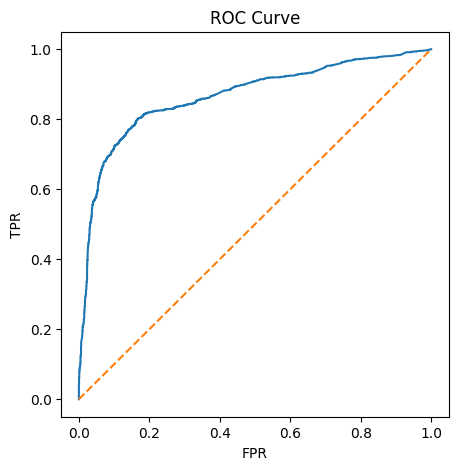

In [ ]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_score)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Control del overfitting
for i in range(1,35):
    dt2 = RandomForestClassifier(max_depth=i, random_state=42, n_estimators=100)
    dt2.fit(X_train, y_train)
    acc_train = dt2.score(X_train, y_train)
    acc_test = dt2.score(X_test, y_test)
    print(f'Profundidad del arbol: {i}, Acc. train: {np.round(acc_train,3)}, Acc. test: {np.round(acc_test,3)}')

Profundidad del arbol: 1, Acc. train: 0.745, Acc. test: 0.737
Profundidad del arbol: 2, Acc. train: 0.76, Acc. test: 0.751
Profundidad del arbol: 3, Acc. train: 0.761, Acc. test: 0.754
Profundidad del arbol: 4, Acc. train: 0.754, Acc. test: 0.749
Profundidad del arbol: 5, Acc. train: 0.763, Acc. test: 0.753
Profundidad del arbol: 6, Acc. train: 0.768, Acc. test: 0.759
Profundidad del arbol: 7, Acc. train: 0.771, Acc. test: 0.76
Profundidad del arbol: 8, Acc. train: 0.773, Acc. test: 0.762
Profundidad del arbol: 9, Acc. train: 0.777, Acc. test: 0.768
Profundidad del arbol: 10, Acc. train: 0.78, Acc. test: 0.772
Profundidad del arbol: 11, Acc. train: 0.783, Acc. test: 0.773
Profundidad del arbol: 12, Acc. train: 0.789, Acc. test: 0.781
Profundidad del arbol: 13, Acc. train: 0.795, Acc. test: 0.794
Profundidad del arbol: 14, Acc. train: 0.801, Acc. test: 0.801
Profundidad del arbol: 15, Acc. train: 0.806, Acc. test: 0.809
Profundidad del arbol: 16, Acc. train: 0.806, Acc. test: 0.81
Profu

# 9. Predicción de la probabilidad de compra de debit_card para el último mes
Se realiza una predicción de la probabilidad de que cada cliente compre debit_card en el último mes. Estos resultados se ordenan por probabilidad y se guardan en un archivo CSV.

In [ ]:
# Creamos el conjunto de datos para el último mes
last_month_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Excluimos a los clientes que ya tienen debit_card
last_month_df = last_month_df[last_month_df[target] == 0]

# Excluimos las ventas
X_last_month = last_month_df[features].copy()

# Normalizamos las características numéricas
X_last_month.loc[:, numeric_features] = scaler.transform(X_last_month[numeric_features])

# Hacemos las predicciones de probabilidad con el modelo
probs = model.predict_proba(X_last_month)

# Conservamos solo la probabilidad de la clase positiva
probs = probs[:, 1]

# Creamos un DataFrame para los resultados
results_debit = pd.DataFrame({
    'pk_cid': last_month_df['pk_cid'],  # reemplazar 'CustomerID' con tu columna de identificación de clientes
    'Probability_debit': probs
})

# Ordenamos de mayor a menor probabilidad
results_debit = results_debit.sort_values(by='Probability_debit', ascending=False)

# Mostramos los resultados
print(results_debit)



         pk_cid  Probability_debit
325255  1408595           0.964946
383717  1477692           0.962816
389199  1483879           0.962575
341327  1428053           0.961462
320020  1401332           0.959939
...         ...                ...
281798  1350586           0.186737
284955  1354281           0.186737
288629  1358451           0.186737
285005  1354338           0.186737
281769  1350556           0.186737

[326933 rows x 2 columns]


In [ ]:
# Supongamos que 'pk_cid' es la columna con los identificadores de cliente
# y 'proba' es la columna con las probabilidades predichas
positive_cid4 = results_debit[results_debit['Probability_debit'] > 0.0]['pk_cid']

# Ahora cruza esto con tu dataframe original
cross_check4 = df[df['pk_cid'].isin(positive_cid4)]

# Verifica que todos los valores en 'pension_plan' son 0
if all(cross_check4['debit_card'] == 0):
    print("All is well: All positive predictions have zero target value!")
else:
    raise ValueError("Some positive predictions have non-zero target value!")

All is well: All positive predictions have zero target value!


In [ ]:
results_debit[results_debit['Probability_debit']>0.5]

,pk_cid,Probability_debit
325255,1408595,0.964946
383717,1477692,0.962816
389199,1483879,0.962575
341327,1428053,0.961462
320020,1401332,0.959939
...,...,...
17360,1020547,0.500029
47060,1057784,0.500018
185447,1227561,0.500014
212229,1267032,0.500007


# 10. Búsqueda de hiperparámetros óptimos
Se realiza una búsqueda aleatoria de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo de XGBoost.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.5, 0.8]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, eval_metric="logloss"),
    param_grid=param_grid,
    cv=3,  # cross-validation
    scoring='roc_auc',
    verbose=2,  # imprimir el progreso
    n_jobs=-1  # usar todos los núcleos disponibles
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Mejores parámetros: ", grid_search.best_params_)
print("Mejor puntaje: ", grid_search.best_score_)
best_model = grid_search.best_estimator_


Mejores parámetros:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Mejor puntaje:  0.8315813250363367


# 11. Entrenamiento del modelo y evaluación de su rendimiento con XGBoost
Se entrena un modelo de XGBoost con los datos de entrenamiento y se evalúa su rendimiento utilizando las métricas de la curva ROC, precisión, recall y F1-score. Se realiza esta evaluación en los conjuntos de entrenamiento, prueba y validación.

In [ ]:
import xgboost as xgb

# Crear y entrenar el modelo
model_xgb = xgb.XGBClassifier(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    subsample=1.0,
    gamma=0,
    colsample_bytree=0.5,
    random_state=42,
    eval_metric="logloss"    # métrica de evaluación para evitar warnings
)
model_xgb.fit(X_train, y_train)

# Predicciones en los conjuntos de entrenamiento, prueba y validación
y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)
y_val_pred_xgb = model_xgb.predict(X_val)

# Predicciones de probabilidad para calcular AUC-ROC
y_train_pred_prob_xgb = model_xgb.predict_proba(X_train)[:, 1]
y_test_pred_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]
y_val_pred_prob_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Evaluar el rendimiento del modelo
print('=== Resultados en el conjunto de entrenamiento ===')
print(classification_report(y_train, y_train_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_train, y_train_pred_xgb))
print('=== Resultados en el conjunto de prueba ===')
print(classification_report(y_test, y_test_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred_xgb))
print('=== Resultados en el conjunto de validación ===')
print(classification_report(y_val, y_val_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred_xgb))



=== Resultados en el conjunto de entrenamiento ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     56000
           1       0.82      0.78      0.80     56000

    accuracy                           0.80    112000
   macro avg       0.81      0.80      0.80    112000
weighted avg       0.81      0.80      0.80    112000

AUC-ROC: 0.804732142857143
=== Resultados en el conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1979
           1       0.84      0.82      0.83      1979

    accuracy                           0.83      3958
   macro avg       0.83      0.83      0.83      3958
weighted avg       0.83      0.83      0.83      3958

AUC-ROC: 0.8302172814552804
=== Resultados en el conjunto de validación ===
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    326933
           1       0.03      0.85      

# 12. Predicción de la probabilidad de compra de una debit_card para el último mes
Se realiza una predicción de la probabilidad de que cada cliente compre debit_card en el último mes. Estos resultados se ordenan por probabilidad y se guardan en un archivo CSV.

In [ ]:
# Creamos el conjunto de datos para el último mes
last_month_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Excluimos a los clientes que ya tienen un debit_card
last_month_df = last_month_df[last_month_df[target] == 0]

# Excluimos las ventas
X_last_month = last_month_df[features].copy()

# Normalizamos las características numéricas
X_last_month.loc[:, numeric_features] = scaler.transform(X_last_month[numeric_features])

# Hacemos las predicciones de probabilidad con el modelo
probs = model_xgb.predict_proba(X_last_month)

# Conservamos solo la probabilidad de la clase positiva
probs = probs[:, 1]

# Creamos un DataFrame para los resultados
results_debit = pd.DataFrame({
    'pk_cid': last_month_df['pk_cid'],
    'Probability_debit': probs
})

# Ordenamos de mayor a menor probabilidad
results_debit = results_debit.sort_values(by='Probability_debit', ascending=False)

# Mostramos los resultados
print(results_debit)


         pk_cid  Probability_debit
341327  1428053           0.994646
414775  1513013           0.994096
415770  1514177           0.992718
383717  1477692           0.991795
46983   1057668           0.991645
...         ...                ...
442976  1551342           0.000410
443386  1551884           0.000409
437048  1543247           0.000389
441057  1548840           0.000315
444465  1553282           0.000314

[326933 rows x 2 columns]


# 13. Análisis de correlación de las variables con el target

Se realiza un análisis de correlación para identificar las variables que tienen una mayor correlación con la variable objetivo, lo que puede indicar qué variables son más importantes para la predicción.

In [ ]:
correlation_with_target = df_grouped.corr()[target]
correlation_with_target = correlation_with_target.drop(target)
sorted_correlations = correlation_with_target.sort_values(ascending=False)
print(sorted_correlations)

<ipython-input-24-1c63af0904c5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = df_grouped.corr()[target]


payroll_account               0.339101
pension_plan                  0.311031
payroll                       0.302974
segment_02 - PARTICULARES     0.260686
entry_channel_KFC             0.188302
                                ...   
region_code_8.0              -0.038300
gender_M                     -0.058801
entry_channel_KHQ            -0.146557
entry_channel_KHE            -0.201755
segment_03 - UNIVERSITARIO   -0.259721
Name: debit_card, Length: 181, dtype: float64


In [ ]:
corr = df_grouped.corr()

<ipython-input-25-27b27b39aada>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_grouped.corr()


In [ ]:
corr.style.background_gradient(cmap='coolwarm')

# 14. Descargamos el archivo con la propabilidad por cliente

In [ ]:
from google.colab import files

# Guardar el dataframe en un archivo CSV
results_debit.to_csv('results_debit.csv', index=False)

# Descargar el archivo CSV
files.download('results_debit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>